# Explainable AI using the Medical MNIST Dataset

**Sources:**

https://medmnist.com/

https://github.com/MedMNIST/MedMNIST

---

Copyright statement:
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

### Explainable AI and GradCAM

Remember our notebook 3 on image classification using the `DermaMNIST` subset of the `MedMNIST` dataset? We were able to observe that even within a short training time-frame, the model already reached a good accuracy (~0.8) and the loss decreased steadily.

Oftentimes, it can be informative and interesting to more deeply understand why and how the model came to its predictions. For skin lesion classification, we often would like to know which part of the skin the model focused on in order to make its predictions. This part of explaining the model is called Explainable AI (xAI) and fortunately, there are many available tools that visualize the decision process of our model. One of these tools is called GradCAM (Gradient-weighted Class Activation Mapping) and is used to generate visual explanations for decisions made by CNNs. It produces a heatmap that highlights the parts of an input image that were most influential in the model's prediction. By visualizing which regions of an image the model focuses on, Grad-CAM helps in understanding the model's decision-making process and can be used for debugging and improving model. Please refer to the [official paper](https://arxiv.org/abs/1610.02391) for more detailed information about the GradCAM implementation.

GradCAM works out of the box on trained models. Hence, in this notebook, we will:

*   Load our previously saved `state_dict` of our `DermaClf` model from notebook 3 and instantiate a new model class
*   

As always, we will first import the necessary dependencies:

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import v2

And set our device accordingly:

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

Device: cpu


### Loading a trained model

Loading a previously saved model is as easy as storing it: you simply load the `state_dict` from the specified storage path. Before we load it, we need to copy our defined model structure in order to instantiate a `DermaClf` class from the `load_state_dict` function.

In [47]:
class DermaClf(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(DermaClf, self).__init__()

    # 5 sequential convolutionsl layers
    self.layer1 = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3),
                                    nn.BatchNorm2d(16), nn.ReLU())

    self.layer2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                                    nn.BatchNorm2d(32), nn.ReLU())

    self.layer3 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    nn.BatchNorm2d(64), nn.ReLU())

    self.layer4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                                    nn.BatchNorm2d(64), nn.ReLU())

    # max pooling layer added
    self.layer5 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(64), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
    # add two fully connected layers
    self.fc = nn.Sequential(nn.Linear(64 * 10 * 10, out_features=512),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(in_features=512, out_features=num_classes))

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)

    x = torch.flatten(x, 1)

    x = self.fc(x)
    return x

model = DermaClf(in_channels=3, num_classes=7)
print(model)

DermaClf(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(

Next, we connect to Google Colab. Don't forget to adjust your `PATH` to where you stored your model.

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now, we load the stored weights into our instantiated class:

In [49]:
model.load_state_dict(torch.load('/content/dermamnist_clf.pt', weights_only=True))
model.eval()

DermaClf(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(

### Preparing the data

If you have received no errors here, that means your model was loaded successfully and can now be used for inference. As a next step, we have to re-instantiate the original dataset and `*DataLoader*` in order to get a test image to classify. For this, let's download the `DermaMNIST` subset again.

In [50]:
!pip install medmnist
import medmnist
from medmnist import DermaMNIST, Evaluator, INFO

In [51]:
transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[.5], std=[.5])
])

In [52]:
BATCH_SIZE=128

test_data = DermaMNIST(split='test', transform=transforms, download=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE)

We also re-initialize our class dictionary:

In [53]:
# inspect unique labels of dataset
class_dict = INFO['dermamnist']['label']
class_dict

{'0': 'actinic keratoses and intraepithelial carcinoma',
 '1': 'basal cell carcinoma',
 '2': 'benign keratosis-like lesions',
 '3': 'dermatofibroma',
 '4': 'melanoma',
 '5': 'melanocytic nevi',
 '6': 'vascular lesions'}

### Implementing Grad-CAM

Now we implement GradCAM in order to visualize the regions in the image that our `DermaClf` focuses on when predicting the corresponding skin lesion class. Below is a simple re-implementation adapted from this [repository implementation](https://github.com/jacobgil/pytorch-grad-cam) for our use-case. The rest of the code for inference and visualization is added and adjusted from the Visualization section from our notebook 3.

For the repository code to work, we first have to install the `grad-cam` package, more information [here](https://pypi.org/project/grad-cam/).

In [54]:
!pip install grad-cam

And then import the relevant packages:

In [55]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt

In a nutshell, GradCAM works the following way:

*    Load any pre-trained or custom trained model like we did in the above cells
*    Specify the last convolutional layer of the network, this is the so-called target layer
*    Do a forward pass, extract the most probable skin lesion class
*    `ClassifierOutputTarget` specifies which class to analyze the input influence for, e.g. "Which parts in the input led the model to predict the class melanocytic nevi?". Since we are only interested in visualizing explanations for the most probable class, this is what we pass
*   Within the `cam` call, a `backward` class is done to capture the gradients needed to determine which parts of the input image were most important for the model's prediction
*   Finally, we generate and overlay a heatmap with the original image, and display our prediction and explanation

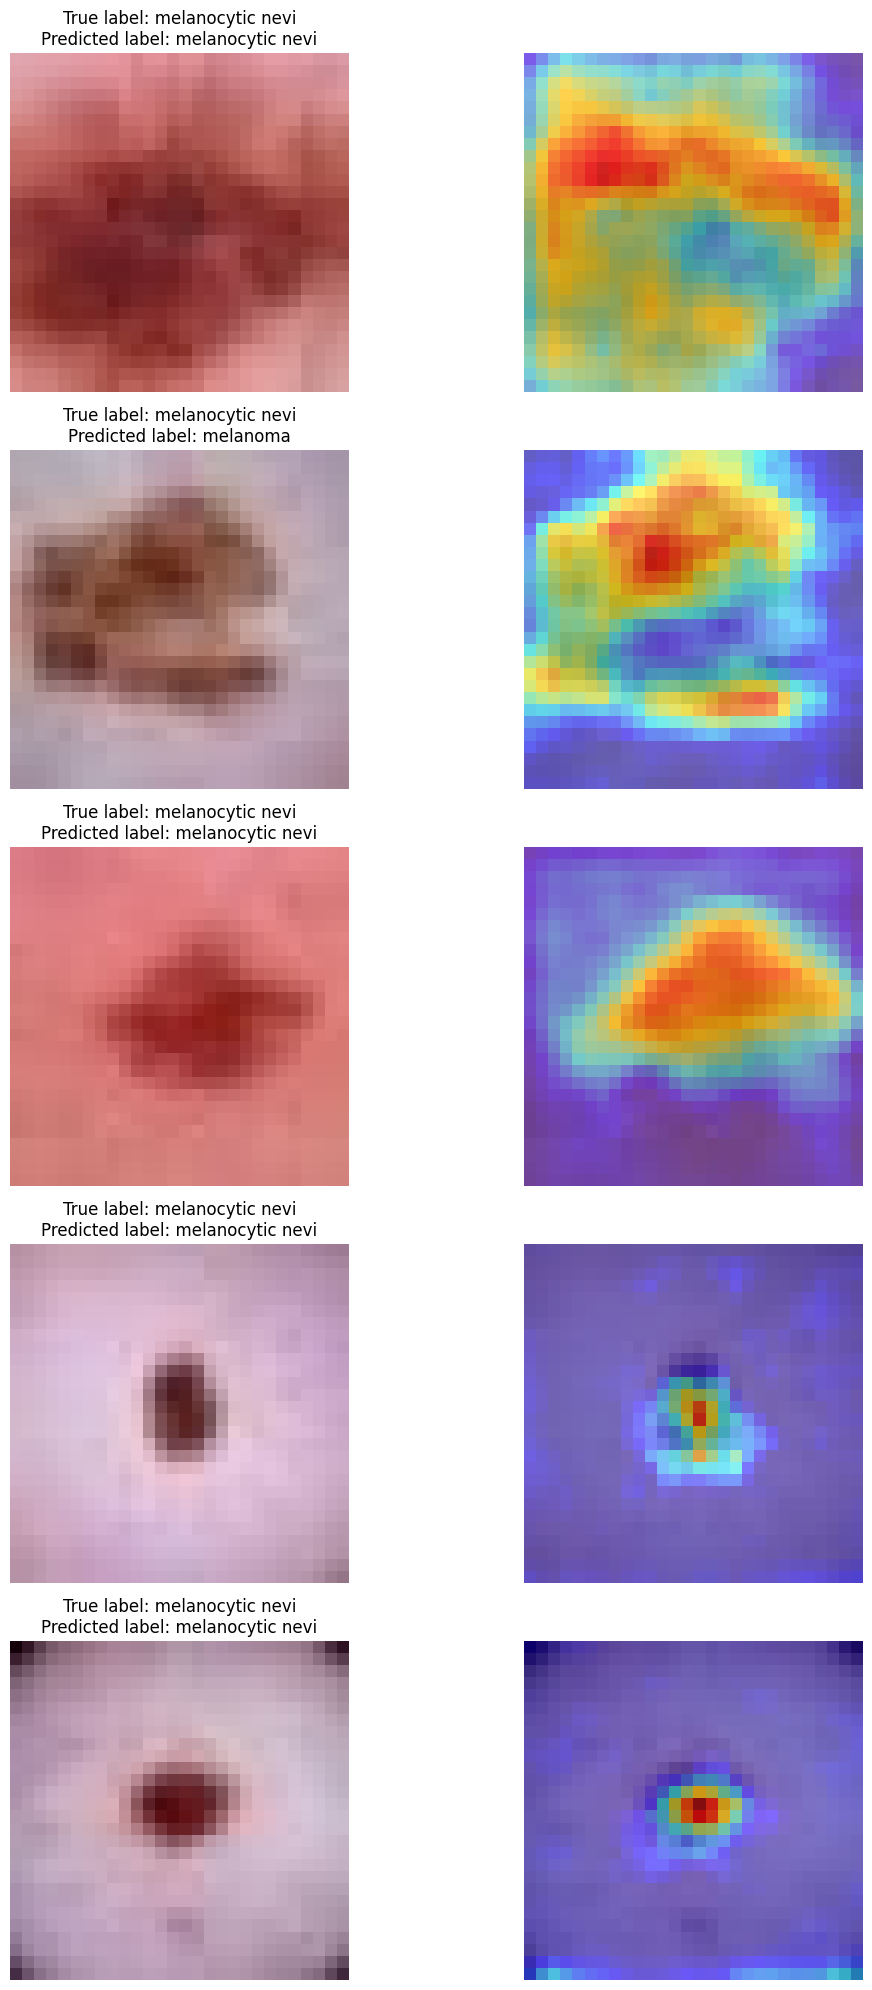

In [62]:
# capture the last conv layer of our model (which is the first (zero-indexing) layer in our 5th Sequential layer)
target_layers = [model.layer5[0]]

# creating the gradcam object
cam = GradCAM(model=model, target_layers=target_layers)

# create plot with 5 rows and 2 columns - rows will be the 5 random imgs, columns for the GradCAM visualization
fig, axes = plt.subplots(5, 2, figsize=(12, 20))

for i in range(5):
  # choose 5 random images from our test set
  rand_idx = np.random.randint(0, len(test_data)-1)
  img, label = test_data[rand_idx]

  # unnormalize for visualization - img * std / mean
  vis_img = (img * 0.5) + 0.5
  vis_img = vis_img.permute(1,2,0).numpy()

  # prepare img for model predictions - add batch dim
  pred_img = img.unsqueeze(0).to(device)

  # forward pass and extract max-probability class
  with torch.no_grad():
      model = model.to(device)
      pred = model(pred_img)
      pred_idx = pred.argmax(dim=1).item()

  # backward pass
  targets = [ClassifierOutputTarget(pred_idx)]
  grayscale_cam = cam(input_tensor=pred_img, targets=targets, aug_smooth=True) # set aug_smooth=True for reducing noise
  grayscale_cam = grayscale_cam[0, :]  # get CAM for first (only) image

  # create GradCAM visualization
  visualization = show_cam_on_image(vis_img, grayscale_cam, use_rgb=True)

  # left col -> Original image
  axes[i, 0].imshow(vis_img)
  axes[i, 0].set_title(
        f"True label: {class_dict[str(label.item())]}\nPredicted label: {class_dict[str(pred_idx)]}"
    )
  axes[i, 0].axis('off')

  # right col -> GradCAM
  axes[i, 1].imshow(visualization)
  axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

The more warm-toned an area is (e.g. the red areas), the more influence this area in the input image had on the final prediction. We observe that for the most part, our model learned pretty well to focus on the relevant parts in the image. It classifies 4/5 examples from the test set here correctly, as well as has the heated areas of its GradCAM headmaps in the (for a human eye) relevant parts of the skin images.